# 스타벅스 입지 분석

## Phase1. EDA
### 1.1 데이터 확인

In [32]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import geopandas as gpd # shp 파일 로드
import contextily as ctx # 서울시 지도 불러올 때

import folium
import folium.plugins as plugins


In [2]:
cd Desktop/prj/상권분석/git/market_area_analysis/

[Errno 2] No such file or directory: 'Desktop/prj/상권분석/git/market_area_analysis/'
/Users/jade/Desktop/prj/market_analysis/git/market_area_analysis


In [3]:
df = pd.read_csv('../processed/analysis_df.csv')

df.head(1)

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시군구명,행정동코드,행정동명,지번주소,도로명주소,경도,...,7세19세,20세25세,26세30세,31세40세,41세50세,51세60세,61세109세,평당거래금액(만원),상권중심점,상권중심점거리
0,부동산임대김은숙,음식,비알코올,카페,종로구,1111054000,삼청동,서울특별시 종로구 삼청동 28-21,서울특별시 종로구 삼청로 122-1,126.98184,...,189,108,143,275,298,333,770,583.0,17,2.03


In [4]:
df.to_csv('../processed/analysis_df.csv', index=False, encoding='utf-8-sig')


In [5]:
df_starbucks = df[df['스타벅스']==1]

df_starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 518203 to 518843
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   상호명         641 non-null    object 
 1   상권업종대분류명    641 non-null    object 
 2   상권업종중분류명    641 non-null    object 
 3   상권업종소분류명    641 non-null    object 
 4   시군구명        641 non-null    object 
 5   행정동코드       641 non-null    int64  
 6   행정동명        641 non-null    object 
 7   지번주소        641 non-null    object 
 8   도로명주소       641 non-null    object 
 9   경도          641 non-null    float64
 10  위도          641 non-null    float64
 11  스타벅스        641 non-null    int64  
 12  근방가게수       641 non-null    int64  
 13  근방음식점수      641 non-null    int64  
 14  근방카페수       641 non-null    int64  
 15  근방지하철역      641 non-null    object 
 16  근방지하철역거리    641 non-null    float64
 17  승차이용객수      641 non-null    float64
 18  승차출근시간대     641 non-null    float64
 19  승차퇴근시간대     641 non-null  

In [6]:
df_cafe = df[df['상권업종소분류명']=='카페']

In [7]:
print(f"스타벅스 매장 수: {df_cafe['스타벅스'].sum()}")
print(f"비 스타벅스 카페 수: {df_cafe[df_cafe['스타벅스']==0]['스타벅스'].count()}")


스타벅스 매장 수: 641
비 스타벅스 카페 수: 21983


## Phase2: 지리적 분석

### 2.1 지역별 분포 분석

In [8]:
df_district_gu = df_starbucks['시군구명'].value_counts().reset_index()
df_district_gu.columns = ['시군구명', '스타벅스_count']
df_district_gu['스타벅스_ratio'] = df_district_gu['스타벅스_count'] / df_district_gu['스타벅스_count'].sum()
df_district_gu['스타벅스_ratio'] = round(df_district_gu['스타벅스_ratio'] *100, 2)
df_district_gu.sort_values(by='스타벅스_ratio', ascending=False, inplace=True)
df_district_gu.reset_index(drop=True, inplace=True)
df_district_gu

,시군구명,스타벅스_count,스타벅스_ratio
0,강남구,95,14.82
1,중구,51,7.96
2,서초구,51,7.96
3,영등포구,42,6.55
4,종로구,42,6.55
5,마포구,37,5.77
6,송파구,37,5.77
7,강서구,32,4.99
8,용산구,25,3.90
9,서대문구,23,3.59


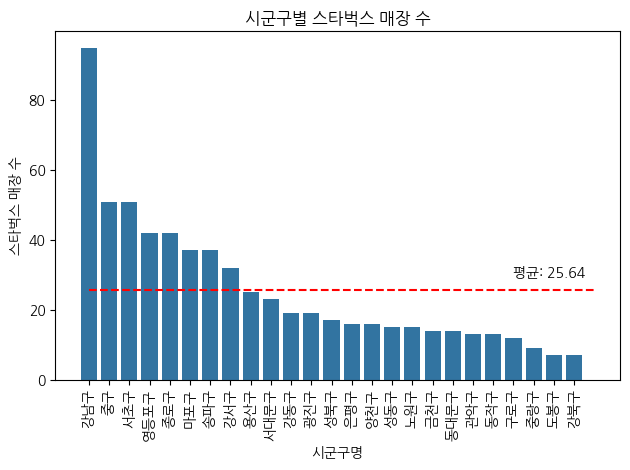

In [9]:
sns.barplot(data=df_district_gu, x='시군구명', y='스타벅스_count')
plt.xticks(rotation=90)
plt.hlines(y=df_district_gu['스타벅스_count'].mean(), xmin=0, xmax=len(df_district_gu), color='red', linestyle='--')
plt.text(x=21, y=df_district_gu['스타벅스_count'].mean()+3, s=f'평균: {df_district_gu["스타벅스_count"].mean():.2f}', ha='left', va='bottom')
plt.xlabel('시군구명')
plt.ylabel('스타벅스 매장 수')
plt.title('시군구별 스타벅스 매장 수')
plt.tight_layout()
plt.show()

In [10]:
df_district_dong = df_starbucks['행정동명'].value_counts().reset_index()
df_district_dong.columns = ['행정동명', '스타벅스_count']
df_district_dong['스타벅스_ratio'] = df_district_dong.iloc[:,1]/641
df_district_dong['스타벅스_ratio'] = round(df_district_dong['스타벅스_ratio'] *100, 2)
df_district_dong.sort_values(by='스타벅스_ratio', ascending=False, inplace=True)
df_district_dong

,행정동명,스타벅스_count,스타벅스_ratio
0,역삼1동,22,3.43
1,여의동,22,3.43
2,종로1.2.3.4가동,18,2.81
3,명동,15,2.34
4,신촌동,12,1.87
...,...,...,...
246,원효로제1동,1,0.16
247,면목제7동,1,0.16
248,상봉제1동,1,0.16
249,묵제1동,1,0.16


### 2.2 공간적 특성 분석
- 시군구, 행정동별
    - 상권 중심점까지의 거리
    - 근방 지하철역까지의 거리
    - 평당 거래 금액(만원)

In [11]:
# df_starbucks.columns
df_starbucks[['상권중심점거리','근방지하철역거리','평당거래금액(만원)']].describe()[1:]

,상권중심점거리,근방지하철역거리,평당거래금액(만원)
mean,1.602574,0.458768,348.077379
std,0.822579,0.504546,334.420143
min,0.070000,0.020000,0.300000
25%,1.020000,0.150000,148.700000
50%,1.530000,0.300000,256.300000
75%,2.030000,0.580000,448.200000
max,5.750000,4.500000,2721.500000


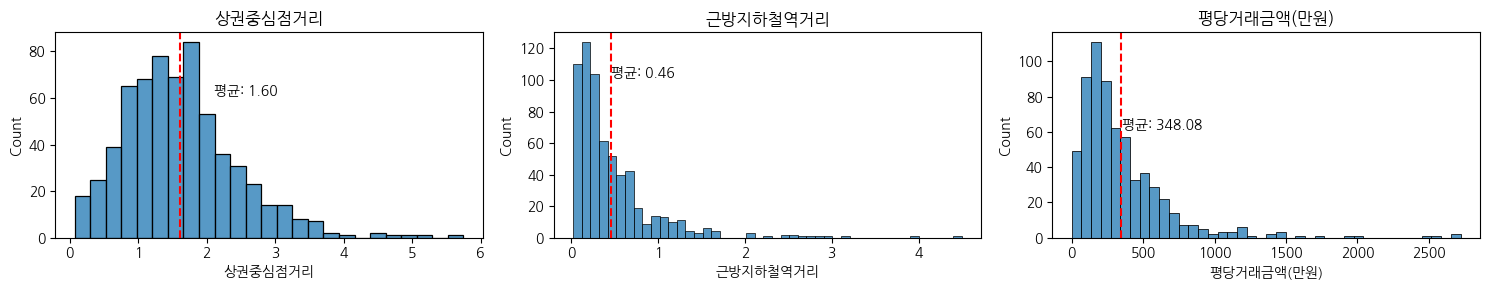

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

sns.histplot(df_starbucks['상권중심점거리'], ax=axes[0])
axes[0].set_title('상권중심점거리')
axes[0].axvline(df_starbucks['상권중심점거리'].mean(), color='red', linestyle='--')
axes[0].text(x=df_starbucks['상권중심점거리'].mean()+0.5, y=60, s=f'평균: {df_starbucks["상권중심점거리"].mean():.2f}', ha='left', va='bottom')

sns.histplot(df_starbucks['근방지하철역거리'], ax=axes[1])
axes[1].set_title('근방지하철역거리')
axes[1].axvline(df_starbucks['근방지하철역거리'].mean(), color='red', linestyle='--')
axes[1].text(x=df_starbucks['근방지하철역거리'].mean(), y=100, s=f'평균: {df_starbucks["근방지하철역거리"].mean():.2f}', ha='left', va='bottom')

sns.histplot(df_starbucks['평당거래금액(만원)'], ax=axes[2])
axes[2].set_title('평당거래금액(만원)')
axes[2].axvline(df_starbucks['평당거래금액(만원)'].mean(), color='red', linestyle='--')
axes[2].text(x=df_starbucks['평당거래금액(만원)'].mean()+1, y=60, s=f'평균: {df_starbucks["평당거래금액(만원)"].mean():.2f}', ha='left', va='bottom')

plt.tight_layout()
plt.show()


In [13]:
df_starbucks.groupby('시군구명')[['상권중심점거리','근방지하철역거리','평당거래금액(만원)']].mean().style.background_gradient(cmap='Blues')

,상권중심점거리,근방지하철역거리,평당거래금액(만원)
시군구명,,,
강남구,1.410632,0.407474,545.375789
강동구,1.940000,0.432632,302.184211
강북구,1.584286,0.661429,100.142857
강서구,1.527500,0.899375,214.993750
관악구,1.432308,0.273846,201.284615
광진구,1.471579,0.265789,287.215789
구로구,1.799167,0.855000,210.041667
금천구,1.284286,1.030714,216.350000
노원구,1.842667,0.545333,173.606667


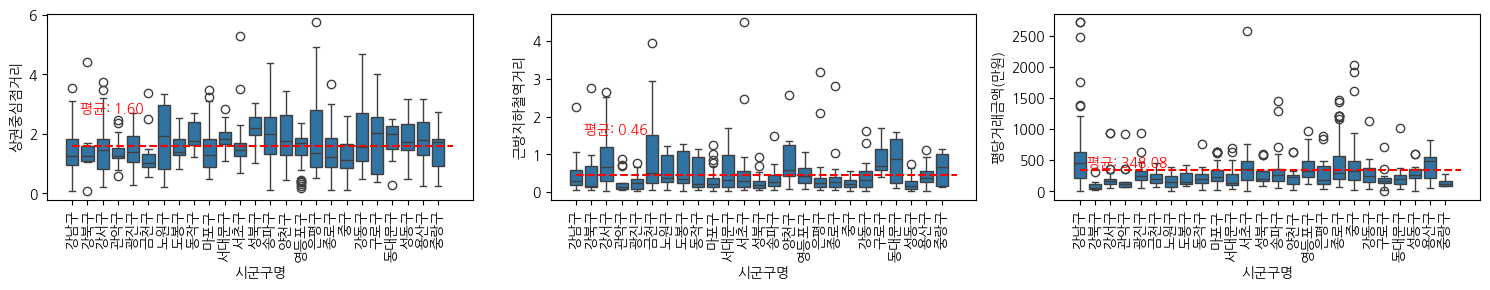

In [14]:
gu_cnt = df_starbucks['시군구명'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

sns.boxplot(data=df_starbucks, x='시군구명', y='상권중심점거리', ax=axes[0])
axes[0].hlines(y=df_starbucks['상권중심점거리'].mean(), xmin=0, xmax=df_starbucks['시군구명'].nunique(), color='red', linestyle='--')
axes[0].set_xticks(gu_cnt)
axes[0].set_xticklabels(gu_cnt, rotation=90)
axes[0].text(x=0.5, y=df_starbucks['상권중심점거리'].mean()+1, s=f'평균: {df_starbucks["상권중심점거리"].mean():.2f}', ha='left', va='bottom', color='red')


sns.boxplot(data=df_starbucks, x='시군구명', y='근방지하철역거리', ax=axes[1])
axes[1].hlines(y=df_starbucks['근방지하철역거리'].mean(), xmin=0, xmax=df_starbucks['시군구명'].nunique(), color='red', linestyle='--')
axes[1].text(x=0.5, y=df_starbucks['근방지하철역거리'].mean()+1, s=f'평균: {df_starbucks["근방지하철역거리"].mean():.2f}', ha='left', va='bottom', color='red')
axes[1].set_xticks(gu_cnt)
axes[1].set_xticklabels(gu_cnt, rotation=90)


sns.boxplot(data=df_starbucks, x='시군구명', y='평당거래금액(만원)', ax=axes[2])
axes[2].hlines(y=df_starbucks['평당거래금액(만원)'].mean(), xmin=0, xmax=df_starbucks['시군구명'].nunique(), color='red', linestyle='--')
axes[2].text(x=0.5, y=df_starbucks['평당거래금액(만원)'].mean()+1, s=f'평균: {df_starbucks["평당거래금액(만원)"].mean():.2f}', ha='left', va='bottom', color='red')
axes[2].set_xticks(gu_cnt)
axes[2].set_xticklabels(gu_cnt, rotation=90)

plt.tight_layout()
plt.show()


<Axes: ylabel='평당거래금액(만원)'>

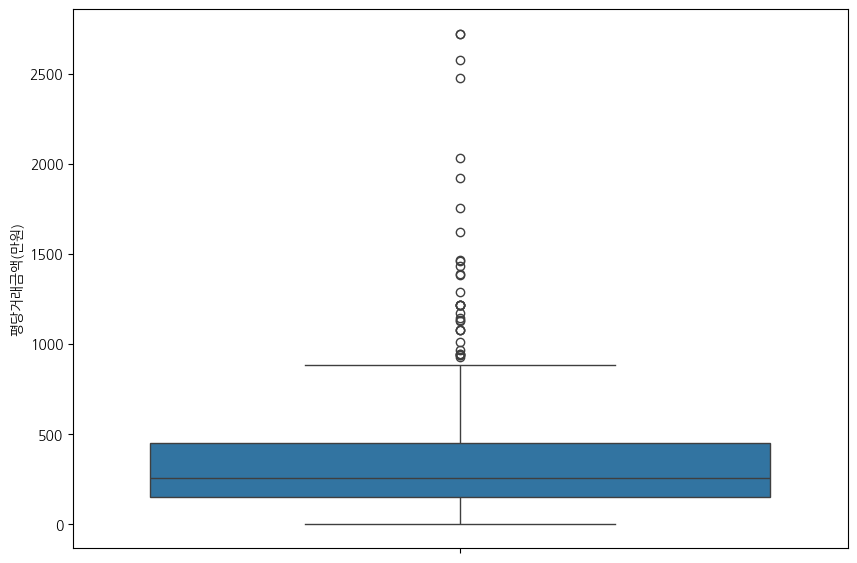

In [15]:
plt.figure(figsize=(10, 7))
plt.xticks(rotation=90)
sns.boxplot(data=df_starbucks, y='평당거래금액(만원)')

In [43]:
cd /Users/jade/Desktop/prj/MARKET_ANALYSIS/git

/Users/jade/Desktop/prj/market_analysis/git


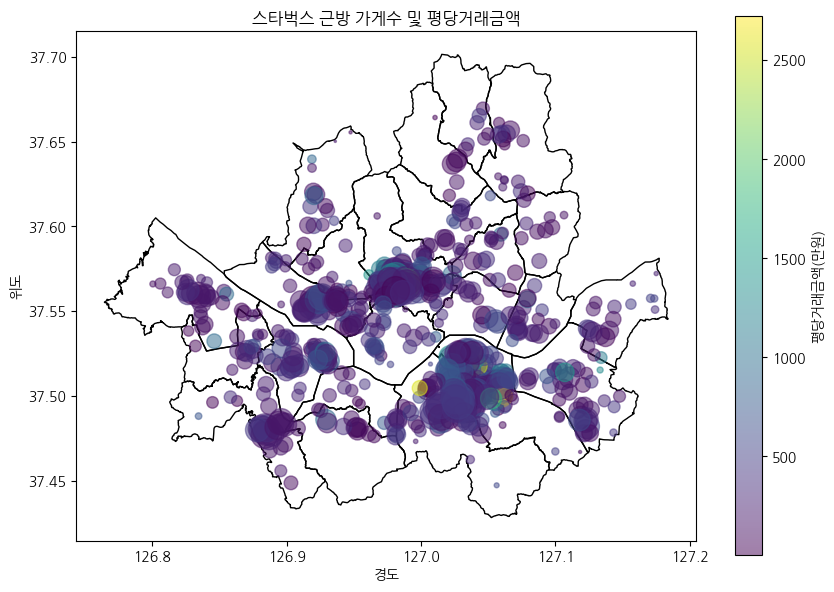

In [48]:
# 스타벅스 위치 
# c: 평당 거래금액(만원)
# s: 인근 가게 수
# current_path = 'Users/jade/Desktop/prj/상권분석/git/market_area_analysis/'
shp_file_path = 'market_area_analysis/shp_files/LARD_ADM_SECT_SGG_11_202502.shp'
# full_path = os.path.join(current_path, shp_file_path)


seoul_boundary = gpd.read_file(shp_file_path) #gpd로 읽고
seoul_boundary = seoul_boundary.to_crs(epsg=4326) #tocrs를 통해 4326으로 변환

fig, ax = plt.subplots(figsize=(10, 7))
seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")

plt.scatter(x=df_starbucks['경도'], 
            y=df_starbucks['위도'], 
            s=df_starbucks['근방가게수']/20, 
            c=df_starbucks['평당거래금액(만원)'],
            alpha=0.5)

plt.xlabel('경도')
plt.ylabel('위도')
plt.title('스타벅스 근방 가게수 및 평당거래금액')
plt.colorbar(label='평당거래금액(만원)')


# ctx.add_basemap(ax=ax,
#                 crs=seoul_boundary.crs, 
#                 source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

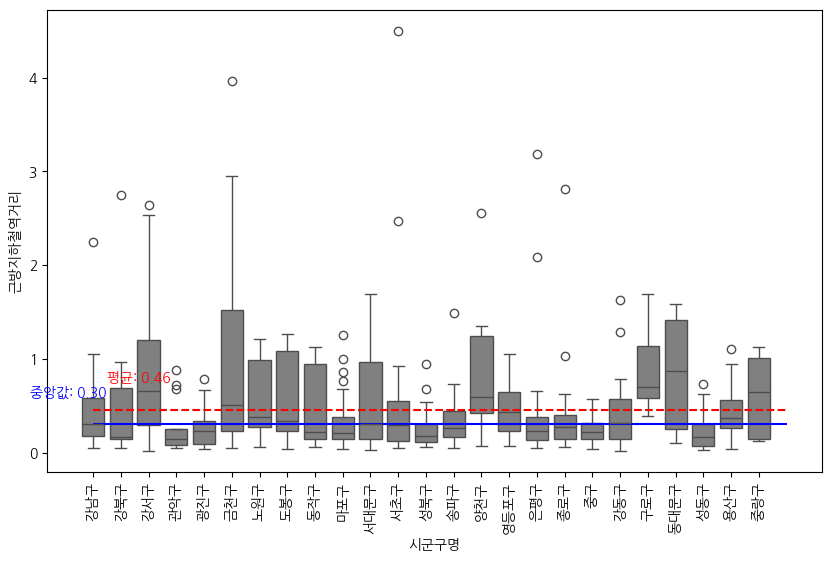

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_starbucks, x='시군구명', y='근방지하철역거리', color='grey')
plt.hlines(df_starbucks['근방지하철역거리'].mean(), xmin=0, xmax=df_starbucks['시군구명'].nunique(), colors='red', linestyles='--')
plt.text(x=0.5, y=df_starbucks['근방지하철역거리'].mean() + 0.3,  s=f'평균: {df_starbucks['근방지하철역거리'].mean():.2f}', color='red')

plt.hlines(df_starbucks['근방지하철역거리'].median(), xmin=0, xmax=df_starbucks['시군구명'].nunique(), colors='blue', linestyles='-')
plt.text(x=0.5, y=df_starbucks['근방지하철역거리'].median() + 0.3,  s=f'중앙값: {df_starbucks['근방지하철역거리'].median():.2f}', ha='right' , color='blue')
plt.xticks(rotation=90)
plt.show()


